In [8]:
# Standard Library
import os
import re
import warnings
import zipfile

# Third-Party Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bootcampviztools import pinta_distribucion_categoricas
from nltk.corpus import stopwords
import nltk

# Configuration
warnings.filterwarnings('ignore')

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [9]:
from datasets import load_dataset

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)

In [10]:
# Convert the entire dataset to a Pandas DataFrame
df_reviews = pd.DataFrame(dataset["full"])

In [11]:
# Reduce the dataset size to 5%
porcentaje_muestra = 5
df_sample = df_reviews.sample(frac=porcentaje_muestra / 100, random_state=42)

# Verify sample size (max. 25 MB) 
sample_size_mb = df_sample.memory_usage(deep=True).sum() / (1024 ** 2)  # MB
print(f"Tamaño de la muestra: {sample_size_mb:.2f} MB")

# Save sample in zipped csv for GitHubuestra en un CSV comprimido (para GitHub)
output_path = r"C:\Users\Vicky\Documents\ML_Amazon_Reviews_Sentiment_Analysis\data_sample/raw/amazon_reviews_sample.csv.gz"
df_sample.to_csv(output_path, index=False, compression="gzip")

print(f"Sample saved in'{output_path}' (memory size: ~25 MB)")

Tamaño de la muestra: 21.14 MB
Sample saved in'C:\Users\Vicky\Documents\ML_Amazon_Reviews_Sentiment_Analysis\data_sample/raw/amazon_reviews_sample.csv.gz' (memory size: ~25 MB)


### Dataset initial exploration 
Let's have a look

In [16]:
df_reviews.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [17]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             701528 non-null  float64
 1   title              701528 non-null  object 
 2   text               701528 non-null  object 
 3   images             701528 non-null  object 
 4   asin               701528 non-null  object 
 5   parent_asin        701528 non-null  object 
 6   user_id            701528 non-null  object 
 7   timestamp          701528 non-null  int64  
 8   helpful_vote       701528 non-null  int64  
 9   verified_purchase  701528 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 48.8+ MB


#### Columns Description
| **Column**          | **DataType** | **Analysis Relevance**                     | **Possible Treatment**                                                                 |
|----------------------|------------------|------------------------------------------------|-------------------------------------------------------------------------------------------|
| `rating`             | `float64`        | **High** (target)                   | Convert to discret ( 1-2 = negative, 3 = neutral, 4-5 = positive).             |
| `title`              | `object`         | **Media** (aditional context)                 | Concatenate with `text` for NLP analysis.                          |
| `text`               | `object`         | **Very High** (primary source)                  | Text Cleaning (stopwords, emojis, URLs), tokenization, y vectorization (TF-IDF/BOW).  |
| `images`             | `object`         | **Low**                                       | **Eliminar**                                   |
| `asin`               | `object`         | **Null**                                       | **Eliminar**                               |
| `parent_asin`        | `object`         | **Null**                                       | **Eliminar**                                                         |
| `user_id`            | `object`         | **Null**                                       | **Eliminar**                                   |
| `timestamp`          | `int64`          | **Low**                                       | **Eliminar**                    |
| `helpful_vote`       | `int64`          | **Medium**                  | Normalize or create flag (ej: `helpful_vote > 5` = highlighted review).                      |
| `verified_purchase`  | `bool`           | **High** (confiability)                      | Convert to binary (1/0) and use it as feature in the model.                             |

I delete null values, duplicates and verify data types are correct

In [21]:
# Create a copy of original dataset
df_reviews_clean = df_reviews.copy()

# Delete nulls in copy
df_reviews_clean = df_reviews_clean.dropna()

# Delete non hashable columns in the columns
df_reviews_clean = df_reviews_clean.drop(columns=['images'])

# Delete duplicates in the copy
df_reviews_clean = df_reviews_clean.drop_duplicates()

# Delete other unnecesary columns in the copy
columnas_a_eliminar = ['asin', 'parent_asin', 'user_id','timestamp']
df_reviews_clean = df_reviews_clean.drop(columns=columnas_a_eliminar)

# See results! 
print("Original DataFrame - Dimensions:", df_reviews.shape)
print("Cleaned DataFrame - Dimensions:", df_reviews_clean.shape)
print("\nFirst rows of cleaned DataFrame:")
df_reviews_clean.head()

Original DataFrame - Dimensions: (701528, 10)
Cleaned DataFrame - Dimensions: (694253, 5)

First rows of cleaned DataFrame:


,rating,title,text,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",1,True
2,5.0,Yes!,"Smells good, feels great!",2,True
3,1.0,Synthetic feeling,Felt synthetic,0,True
4,5.0,A+,Love it,0,True


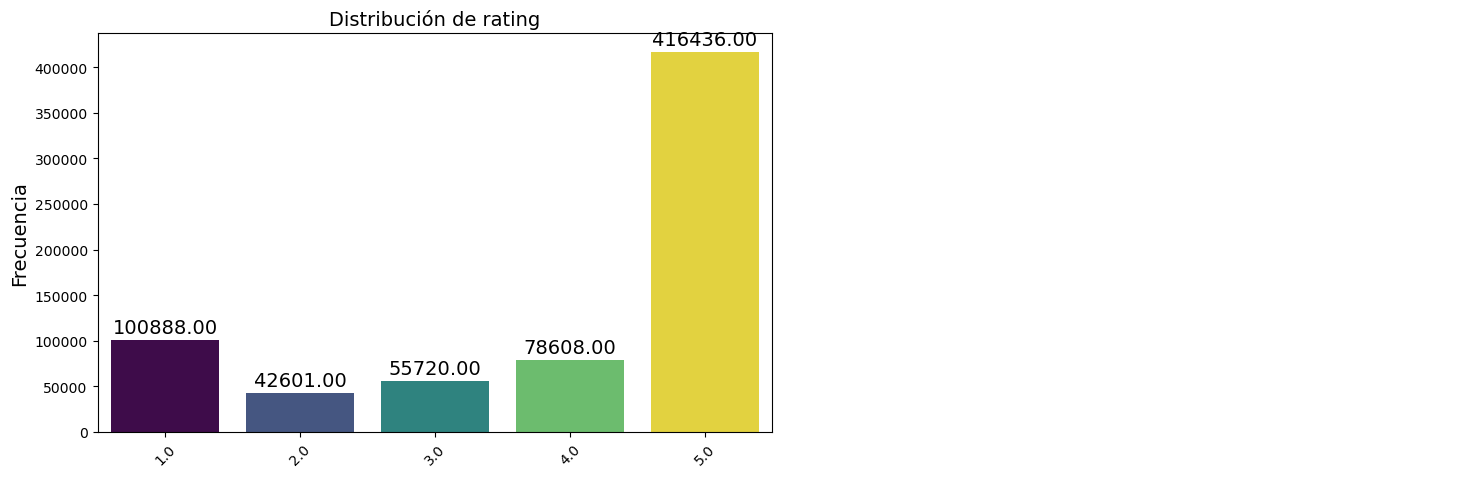

In [22]:
# 'rating' column graphic distribution 
pinta_distribucion_categoricas(df_reviews_clean, columnas_categoricas=['rating'], mostrar_valores=True)

In [26]:
# Create a new column for lenght with text lenght.
df_reviews_clean['length'] = df_reviews_clean['text'].apply(len)


In [28]:
# Calculate average lenght
average_length = df_reviews_clean['length'].mean()
print(f"Average review lenght: {average_length:.2f} characters.")

Average review lenght: 173.10 characters.


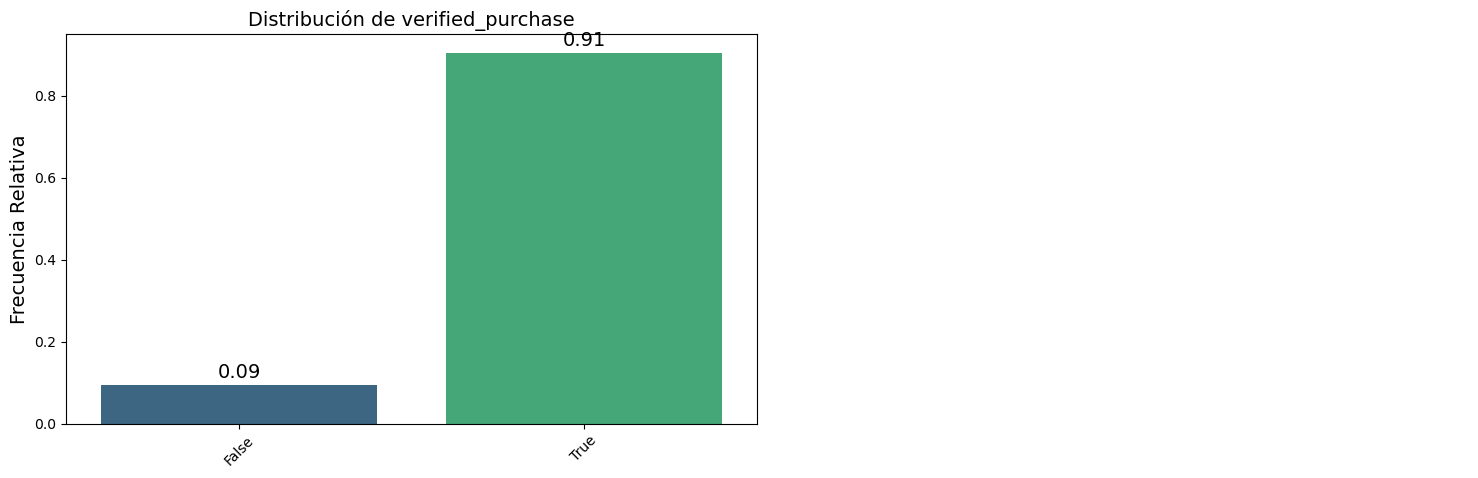

In [30]:
# Verified purchase frequency distribution
pinta_distribucion_categoricas(df_reviews_clean, columnas_categoricas=['verified_purchase'], relativa=True, mostrar_valores=True)
